In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, \
    GlobalAveragePooling2D, Dense, Concatenate, AveragePooling2D


def conv_block(input_layer,
               filters,
               kernel_size):
    output_layer = BatchNormalization()(input_layer)
    output_layer = ReLU()(output_layer)
    return Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  padding='same',
                  use_bias=False,
                  kernel_initializer='he_normal')(output_layer)


def dense_layer(input_layer,
                filters_multiplier,
                output_filters):
    output_layer = conv_block(input_layer,
                              filters_multiplier * output_filters,
                              (1, 1))
    output_layer = conv_block(output_layer,
                              output_filters,
                              (3, 3))
    return Concatenate()([input_layer, output_layer])


def dense_block(input_layer,
                filters_multiplier,
                output_filters,
                dense_layers):
    output_layer = input_layer
    for i in range(dense_layers):
        output_layer = dense_layer(output_layer,
                                   filters_multiplier,
                                   output_filters)
    return output_layer


def transition_block(input_layer,
                     reduction_factor):
    output_layer = conv_block(input_layer,
                              int(input_layer.shape[-1] * reduction_factor),
                              (1, 1))
    return AveragePooling2D(pool_size=(2, 2),
                            strides=2)(output_layer)


def reduced_dense_net():
    input_layer = Input(shape=(28, 28, 1))

    output_layer = Conv2D(filters=64,
                          kernel_size=(3, 3),
                          padding='same',
                          use_bias=False,
                          kernel_initializer='he_normal')(input_layer)
    output_layer = BatchNormalization()(output_layer)
    output_layer = ReLU()(output_layer)

    output_layer = dense_block(output_layer, 4, 32, 3)
    output_layer = transition_block(output_layer, 0.5)
    output_layer = dense_block(output_layer, 4, 32, 6)
    output_layer = transition_block(output_layer, 0.5)
    output_layer = dense_block(output_layer, 4, 32, 9)
    output_layer = transition_block(output_layer, 0.5)

    output_layer = BatchNormalization()(output_layer)
    output_layer = ReLU()(output_layer)

    embedding = GlobalAveragePooling2D()(output_layer)

    predictions = Dense(units=10,
                        kernel_initializer='glorot_normal',
                        activation='softmax')(embedding)

    return Model(inputs=input_layer, outputs=predictions)


def pre_process(image):
    return (image / 127.5 - 1.0).reshape(28, 28, 1)


def to_one_hot_encoding(label):
    encoding = [0.0] * 10
    encoding[label] = 1.0
    return encoding


In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = [pre_process(image) for image in train_images]
test_images = [pre_process(image) for image in test_images]

train_labels = [to_one_hot_encoding(label) for label in train_labels]
test_labels = [to_one_hot_encoding(label) for label in test_labels]

model = reduced_dense_net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 28, 28, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

model.fit(x=np.array(train_images),
          y=np.array(train_labels),
          validation_data=(np.array(test_images),
                          np.array(test_labels)),
          batch_size=128,
          validation_batch_size=1024,
          epochs=20)

Epoch 1/20
469/469 [==============================] - 99s 133ms/step - loss: 0.2514 - categorical_accuracy: 0.9316 - val_loss: 0.0748 - val_categorical_accuracy: 0.9761
Epoch 2/20
469/469 [==============================] - 58s 123ms/step - loss: 0.0342 - categorical_accuracy: 0.9895 - val_loss: 0.2406 - val_categorical_accuracy: 0.9234
Epoch 3/20
469/469 [==============================] - 59s 126ms/step - loss: 0.0251 - categorical_accuracy: 0.9924 - val_loss: 0.0432 - val_categorical_accuracy: 0.9868
Epoch 4/20
469/469 [==============================] - 59s 126ms/step - loss: 0.0191 - categorical_accuracy: 0.9941 - val_loss: 0.0366 - val_categorical_accuracy: 0.9891
Epoch 5/20
469/469 [==============================] - 59s 126ms/step - loss: 0.0158 - categorical_accuracy: 0.9948 - val_loss: 0.0397 - val_categorical_accuracy: 0.9874
Epoch 6/20
469/469 [==============================] - 59s 126ms/step - loss: 0.0147 - categorical_accuracy: 0.9953 - val_loss: 0.0374 - val_categorical_acc

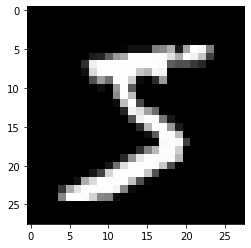

predicted label: 5
true label: 5


In [5]:
from matplotlib import pyplot as plt

image = (train_images[0] + 1.0) * 127.5
image = image.reshape(28, 28).astype(np.uint8)

plt.imshow(image, plt.cm.gray)
plt.show()

predicted_label = np.argmax(model.predict(np.array([train_images[0]]))[0])
true_label = np.argmax(train_labels[0])

print(f'predicted label: {predicted_label}')
print(f'true label: {true_label}')